# PyTorch scaling benchmark analysis

Throughput scaling of PyTorch benchmarks with `DistributedDataParallel` on
- Cori Haswell with Cray MPI
- Cori GPU with NCCL

In [1]:
import os
import re
import glob

import pandas as pd

import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
plt.rcParams.update({'font.size': 14})

## Utilities

In [4]:
def plot_scaling(ranks, rates, title=None, loglog=False):

    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
    
    # Compute ideal scaling relative to lowest rank
    ideal_rates = rates[0] * ranks / ranks[0]

    # Plot throughput scaling
    ax0.plot(ranks, rates, '.-', ms=15, label='measured')
    ax0.plot(ranks, ideal_rates, '--', label='ideal')
    ax0.set_xlabel('Number of nodes')
    ax0.set_ylabel('Training throughput [samples/s]')
    if loglog:
        ax0.set_xscale('log')
        ax0.set_yscale('log')
    else:
        ax0.set_ylim(bottom=0)
    ax0.grid()
    ax0.legend(loc=0)

    # Plot the fraction of ideal scaling
    ax1.semilogx(ranks, rates / ideal_rates, '.-', ms=15)
    ax1.set_xlabel('Number of nodes')
    ax1.set_ylabel('Fraction of ideal scaling')
    ax1.grid()
    ax1.set_ylim(bottom=0)
    
    if title is not None:
        ax0.set_title(title)
        ax1.set_title(title)

    plt.tight_layout()
    return fig, ax0, ax1

## Load the results data

In [5]:
results_files = glob.glob('/global/cscratch1/sd/sfarrell/pytorch-benchmarks/results/hsw-1.7.1-mpi-n*/results.txt')

results_files

['/global/cscratch1/sd/sfarrell/pytorch-benchmarks/results/hsw-1.7.1-mpi-n32/results.txt',
 '/global/cscratch1/sd/sfarrell/pytorch-benchmarks/results/hsw-1.7.1-mpi-n64/results.txt',
 '/global/cscratch1/sd/sfarrell/pytorch-benchmarks/results/hsw-1.7.1-mpi-n2/results.txt',
 '/global/cscratch1/sd/sfarrell/pytorch-benchmarks/results/hsw-1.7.1-mpi-n8/results.txt',
 '/global/cscratch1/sd/sfarrell/pytorch-benchmarks/results/hsw-1.7.1-mpi-n4/results.txt',
 '/global/cscratch1/sd/sfarrell/pytorch-benchmarks/results/hsw-1.7.1-mpi-n1/results.txt',
 '/global/cscratch1/sd/sfarrell/pytorch-benchmarks/results/hsw-1.7.1-mpi-n16/results.txt']

In [6]:
results = [pd.read_csv(f, delim_whitespace=True) for f in results_files]
results = pd.concat(results, ignore_index=True)

results

,train_rate,inference_rate,ranks,hardware,version,backend,model
0,268.204806,1106.046557,32,hsw,1.7.1,mpi,transformer
1,22546.286061,63772.625067,32,hsw,1.7.1,mpi,lstm
2,3487.043518,19895.320808,32,hsw,1.7.1,mpi,alexnet
3,346.830653,1734.421450,32,hsw,1.7.1,mpi,resnet50
4,1288.642898,3113.242383,32,hsw,1.7.1,mpi,cnn3d
5,535.597880,2222.775420,64,hsw,1.7.1,mpi,transformer
6,42636.043303,127108.260889,64,hsw,1.7.1,mpi,lstm
7,6315.829029,44433.061154,64,hsw,1.7.1,mpi,alexnet
8,612.330169,3428.196271,64,hsw,1.7.1,mpi,resnet50
9,2462.157782,6285.847707,64,hsw,1.7.1,mpi,cnn3d


## Training throughput scaling

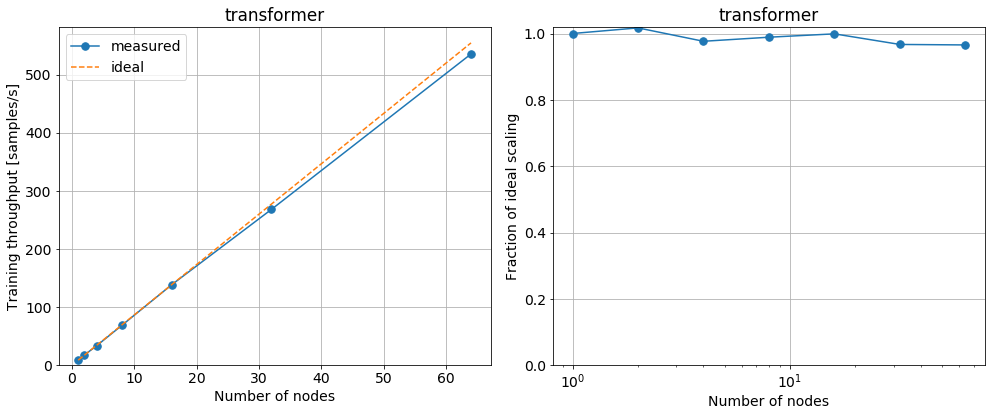

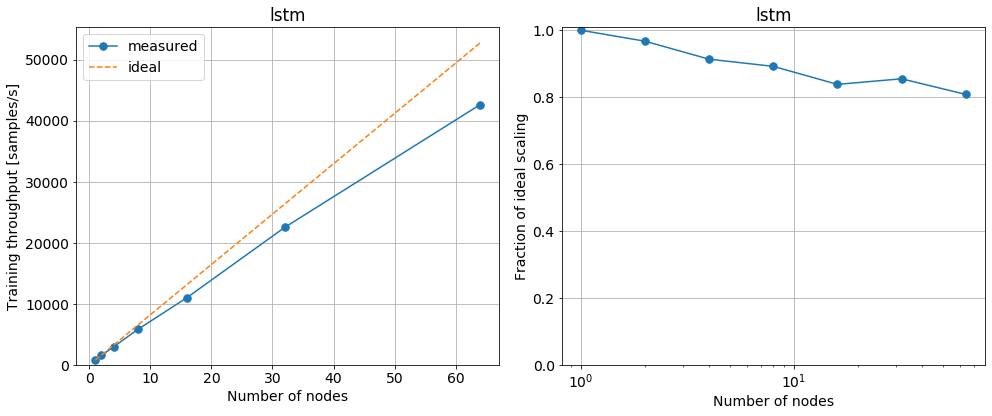

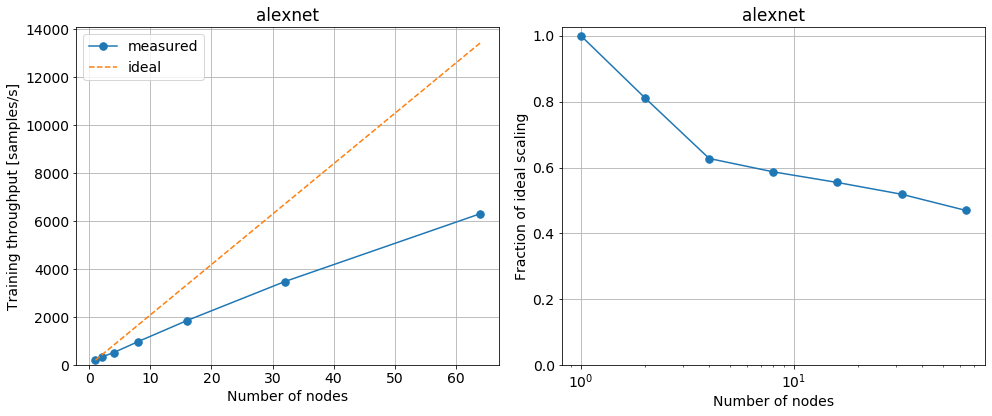

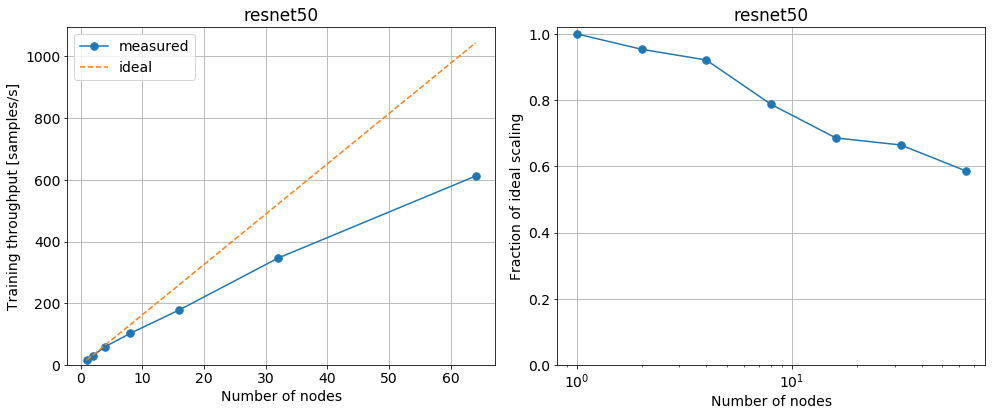

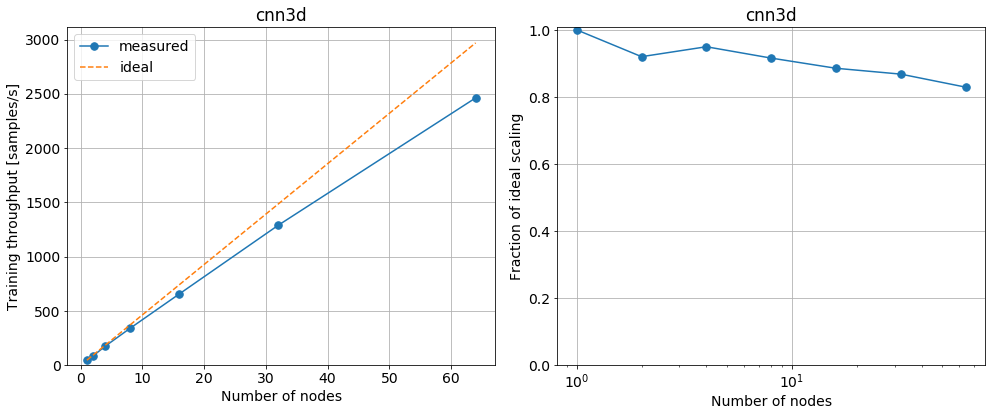

In [7]:
for model in results.model.unique():
    model_results = results[results.model == model].sort_values('ranks')
    fig, ax0, ax1 = plot_scaling(model_results.ranks.values,
                                 model_results.train_rate.values,
                                 title=model)

## Inference throughput scaling

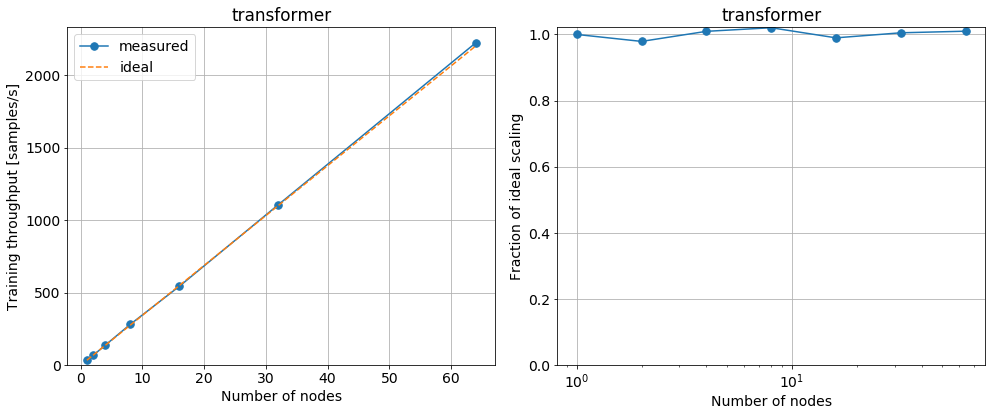

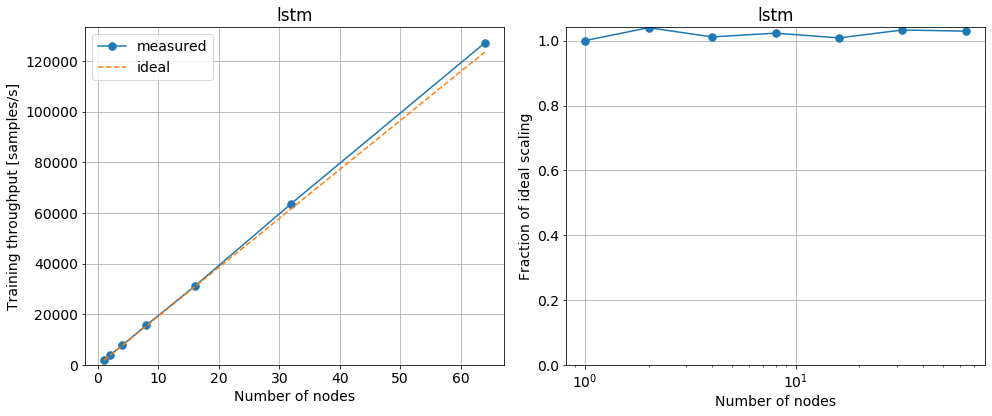

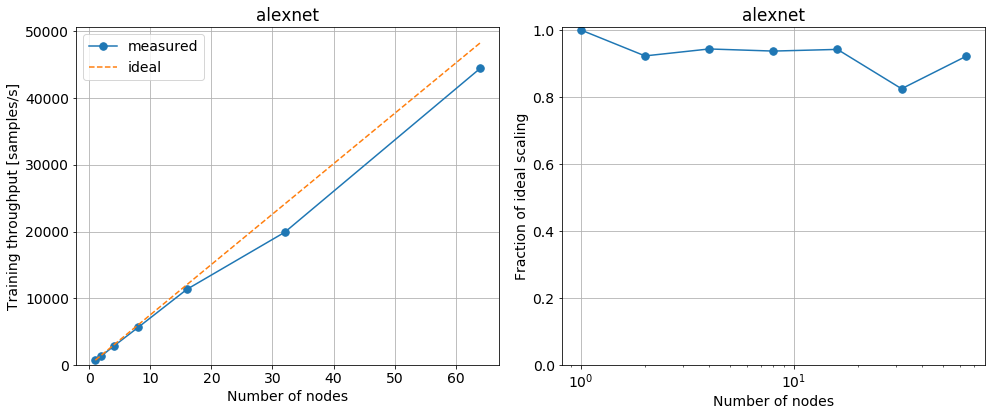

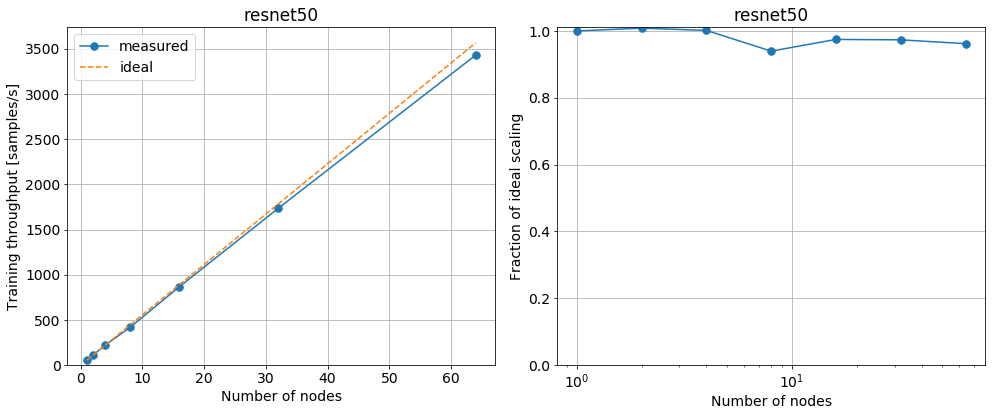

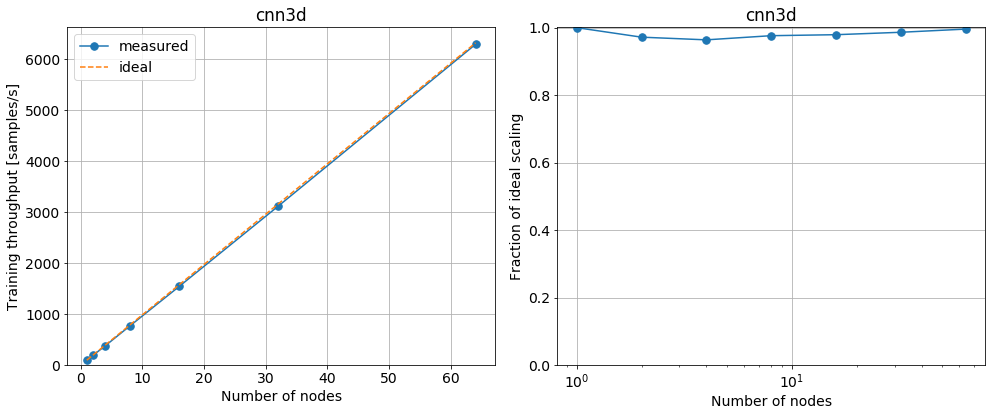

In [8]:
for model in results.model.unique():
    model_results = results[results.model == model].sort_values('ranks')
    fig, ax0, ax1 = plot_scaling(model_results.ranks.values,
                                 model_results.inference_rate.values,
                                 title=model)